In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from lime.lime_tabular import LimeTabularExplainer

from mountaineer import Mountaineer
from gale import create_mapper, bootstrap_mapper_params, bottleneck_distance
from gale.plots import plot_mapper, plot_ext_persistance_diagram
from gudhi.cover_complex import MapperComplex

np.random.seed(42)

/home/vitoria/anaconda3/envs/mountaineer/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vitoria/anaconda3/envs/mountaineer/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vitoria/anaconda3/envs/mountaineer/lib/python3.9/site-

In [2]:
data_name = 'ACSEmployment'
data_path = f'dataset/{data_name}/'

if Path(data_path+'X_train.csv').is_file():
    print('Processed data found. Loading...', end='')
    X_train = pd.read_csv(data_path+'X_train.csv')
    X_test = pd.read_csv(data_path+'X_test.csv')
    y_train = pd.read_csv(data_path+'y_train.csv')
    y_test = pd.read_csv(data_path+'y_test.csv')
    print('done.\n')

else:
    print('Processed data not found.')

    from folktables import ACSDataSource, ACSEmployment

    print('Downloading data...', end='')
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=['NY'])
    variables, target, group = ACSEmployment.df_to_pandas(acs_data)
    target = target['ESR']
    print('done.')

    print('Processing data...', end='')
    # Remove people under 18
    age_mask = variables['AGEP'] >= 18
    variables = variables[age_mask]
    target = target[age_mask].astype(int)
    # Map binary features
    bin_columns = ['SEX', 'DIS', 'DEAR', 'DEYE', 'DREM']
    variables['MALE'] = variables['SEX'].map({1: 1, 2: 0})
    # variables['DISABILITY'] = variables['DIS'].map({1: 1, 2: 0}) # Remove disability
    variables['HEARING_DIFFICULTY'] = variables['DEAR'].map({1: 1, 2: 0})
    variables['VISION_DIFICULTY'] = variables['DEYE'].map({1: 1, 2: 0})
    variables['COGNITIVE_DIFFICULTY'] = variables['DREM'].map({1: 1, 2: 0})
    variables.drop(columns=bin_columns, inplace=True)
    # Map categorical features
    cat_columns = ['MIL', 'MIG', 'MAR', 'RAC1P', 'CIT']
    variables['BEEN_MILITARY'] = variables['MIL'].map({1: 1, 2: 1, 3: 1, 4: 0})
    variables['MOBILITY'] = variables['MIG'].map({1: 0, 2: 1, 3: 1})
    variables['MARRIED'] = variables['MAR'].map({1: 1, 2: 0, 3: 0, 4: 0, 5: 0})
    variables['WHITE'] = variables['RAC1P'].map({1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0})
    #variables['HIGH_SCHOOL'] = (variables['SCHL'] > 15).astype(int)
    #variables['COLLEGE'] = (variables['SCHL'] > 17).astype(int)
    #variables['GRAD_SCHOOL'] = (variables['SCHL'] > 21).astype(int)
    variables['NATURALIZED'] = (variables['CIT'] == 4).astype(int)
    variables['NOT_US_CITIZEN'] = (variables['CIT'] == 5).astype(int)
    variables.drop(columns=cat_columns, inplace=True)
    
    # Features to drop
    drop_columns = ['ESP', 'RELP', 'ANC', 'NATIVITY']
    variables.drop(columns=drop_columns, inplace=True)
    print('done.')

    print('Splitting and saving train and test data...', end='')
    # Splitting
    X_train, X_test, y_train, y_test = train_test_split(variables, target, test_size=0.3, random_state=42)
    # Scale numerical features
    scaler = StandardScaler()
    scaler.fit(X_train[['AGEP', 'SCHL']])
    X_train[['AGEP', 'SCHL']] = scaler.transform(X_train[['AGEP', 'SCHL']])
    X_test[['AGEP', 'SCHL']] = scaler.transform(X_test[['AGEP', 'SCHL']])
    # Saving
    X_train.to_csv(data_path+'X_train.csv', index=False)
    X_test.to_csv(data_path+'X_test.csv', index=False)
    y_train.to_csv(data_path+'y_train.csv', index=False)
    y_test.to_csv(data_path+'y_test.csv', index=False)
    print('done.\n')

X_train_np = X_train.values
X_test_np = X_test.values
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(f"Number of samples: Train {X_train.shape[0]} | Test {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Train - Class 0: {y_train[y_train==0].shape[0]} | Class 1: {y_train[y_train==1].shape[0]}")
print(f"Test - Class 0: {y_test[y_test==0].shape[0]} | Class 1: {y_test[y_test==1].shape[0]}")

Processed data found. Loading...done.

Number of samples: Train 111509 | Test 47790
Number of features: 12
Train - Class 0: 48081 | Class 1: 63428
Test - Class 0: 20455 | Class 1: 27335


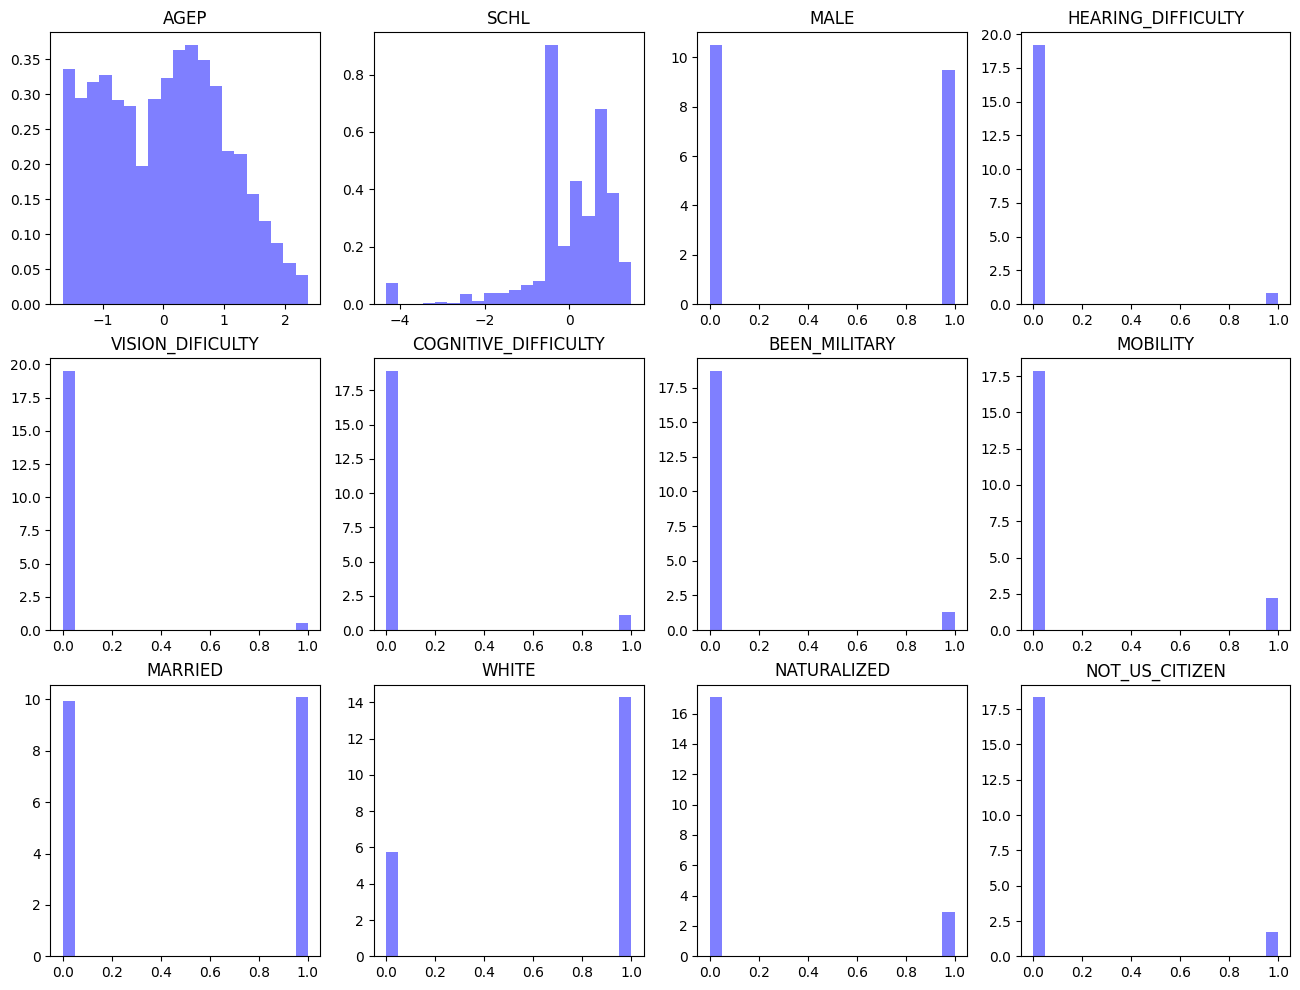

In [3]:
import matplotlib.pyplot as plt

cols = X_train.columns

fig, axs = plt.subplots(3, 4, figsize=(16, 12))

for i, col in enumerate(cols):
    ix = i%4
    iy = i//4

    axs[iy, ix].hist(X_train[col], bins=20, alpha=0.5, label='Train', color='blue', density=True)
    axs[iy, ix].set_title(col)

In [4]:
names = [
    "Logistic Regression",
    "RBF SVM",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "XGBoost"
]

skmodels_path = data_path+'skmodels.p'

if Path(skmodels_path).is_file():
    print('Models found. Loading...')
    classifiers = pickle.load(open(skmodels_path, 'rb'))
    scores = pickle.load(open(data_path+'model_scores.p', 'rb'))
    for name, clf in zip(names, classifiers):
        print(f"{name} - Accuracy: {scores[name]:.4f}")
    print('Done.\n')

else:
    print('Models not found.')
    classifiers = [
        LogisticRegression(max_iter=1000),
        SVC(kernel='rbf', gamma='scale', C=1, probability=True),
        CalibratedClassifierCV(RandomForestClassifier(n_estimators=100, min_samples_split=10), method='isotonic'),
        MLPClassifier(alpha=0.01, max_iter=1000, learning_rate='adaptive', learning_rate_init=0.005,
                                early_stopping=True, hidden_layer_sizes=(128,)),
        CalibratedClassifierCV(AdaBoostClassifier(n_estimators=500), method='isotonic'),
        CalibratedClassifierCV(XGBClassifier(), method='isotonic')
    ]
    scores = {}

    for name, clf in zip(names, classifiers):
        print(f"Training {name}...", end=' ')
        clf.fit(X_train_np, y_train)
        score = clf.score(X_test_np, y_test)
        scores[name] = score
        print(f"done. Accuracy: {score:.4f}")
    
    print('Saving models...', end='')
    pickle.dump(classifiers, open(skmodels_path, 'wb'))
    pickle.dump(scores, open(data_path+'model_scores.p', 'wb'))
    print('done.\n')

Models found. Loading...
Logistic Regression - Accuracy: 0.7199
RBF SVM - Accuracy: 0.7645
Random Forest - Accuracy: 0.7623
Neural Net - Accuracy: 0.7668
AdaBoost - Accuracy: 0.7637
XGBoost - Accuracy: 0.7707
Done.



In [5]:
predictions_path = data_path+'skmodels_pred.p'

if Path(predictions_path).is_file():
    print('Predictions found. Loading...', end='')
    predictions = pickle.load(open(predictions_path, 'rb'))
    print('done.\n')

else:
    print('Predictions not found.')
    predictions = {}
    for name, clf in zip(names, classifiers):
        print(f"Generating predictions for {name}...", end=' ')
        predictions[name] = clf.predict_proba(X_test_np)[:, 1]
        print(f"done.")
    
    print('Saving predictions...', end='')
    pickle.dump(predictions, open(predictions_path, 'wb'))
    print('done.\n')

Predictions found. Loading...done.



In [6]:
def run_lime(X, model, num_features=5, num_samples=1000):
    explainer = LimeTabularExplainer(X, 
                                    #categorical_features=list(range(1,len(X.columns))),
                                    discretize_continuous=False, 
                                    sample_around_instance=True,
                                    random_state=2023)
    lime_exp = []
    for x in X:
        exp = explainer.explain_instance(x, model.predict_proba, 
                                        num_features=num_features, 
                                        num_samples=num_samples)
        tmp = [0 for i in range(X.shape[1])]

        for e in exp.as_list():
            tmp[int(e[0])] = e[1]
        lime_exp.append(tmp)
    lime_exp = np.array(lime_exp)
    return lime_exp


In [7]:
lime_exp_path = data_path+'lime_exp.p'

if Path(lime_exp_path).is_file():
    print('LIME explanations found. Loading...', end='')
    lime_exp = pickle.load(open(lime_exp_path, 'rb'))
    print('done.\n')

else:
    print('LIME explanations not found.')
    lime_exp = {}
    
    for name, clf in zip(names, classifiers):
        if name == "Logistic Regression":
            continue
        print(f"Running LIME for {name}...", end=' ')
        lime_exp[name] = run_lime(X_test_np, clf, num_features=5, num_samples=500)
        print("done.")

    print('Saving LIME explanations...', end='')
    pickle.dump(lime_exp, open(lime_exp_path, 'wb'))
    print('done.\n')

print('Getting Logistic Regression "explanations"...', end=' ')
logreg_coef = classifiers[0].coef_
logreg_expl = np.zeros((X_test_np.shape[0], X_test_np.shape[1]))
for i in range(X_test_np.shape[0]):
    logreg_expl[i,:] = logreg_coef
print('done.\n')

LIME explanations found. Loading...done.

Getting Logistic Regression "explanations"... 

done.



In [8]:
delta_path = data_path+'deltas.p'

if Path(delta_path).is_file():
    deltas = pickle.load(open(delta_path, 'rb'))

else:
    deltas = {}

    for name in names[1:]:
        mapper = MapperComplex(input_type="point cloud")
        if name == "Logistic Regression":
            deltas[name] = mapper.estimate_scale(logreg_expl, N=500, beta=0.001)
        else:
            deltas[name] = mapper.estimate_scale(lime_exp[name], N=500, beta=0.001)
        print(f'Delta for {name}: {deltas[name]}')

    pickle.dump(deltas, open(delta_path, 'wb'))

In [10]:
params_path = data_path+'mapper_params.p'

gain = 0.4
min_points_per_node = 0
resolutions = [i for i in range(15, 30)]

if Path(params_path).is_file():
    print('Parameters found.')
    mapper_params = pickle.load(open(params_path, 'rb'))
    for name in names:
        print(f'Parameters for {name}: {mapper_params[name]}')

else:
    mapper_params = {}

    for name in names[1:]:
        mapper_params[name] = bootstrap_mapper_params(lime_exp[name], predictions[name],
                                                    resolutions=resolutions,
                                                    gains=[gain],
                                                    distances=[deltas[name]],
                                                    min_points_per_node=[min_points_per_node],
                                                    n=100, seed=2023,
                                                    n_jobs=-1)
        print(f'Parameters for {name}: {mapper_params[name]}')

    mapper_params['Logistic Regression'] = {'stability': 0, 
                                            'components': 1,
                                            'resolution': 15,
                                            'gain': 0.4,
                                            'distance_threshold': 0.0001
                                            }

    pickle.dump(mapper_params, open(params_path, 'wb'))

KeyboardInterrupt: 

In [ ]:
mappers = {}

mappers['Logistic Regression'] = create_mapper(logreg_expl, predictions['Logistic Regression'],
                                                resolution=mapper_params['Logistic Regression']['resolution'], 
                                                gain=mapper_params['Logistic Regression']['gain'], 
                                                dist_thresh=mapper_params['Logistic Regression']['distance_threshold'],
                                                min_points_per_node=min_points_per_node)
print(f'Mapper for Logistic Regression created.')

for name in names[1:]:
    mappers[name] = create_mapper(lime_exp[name], predictions[name],
                                  resolution=mapper_params[name]['resolution'], 
                                  gain=mapper_params[name]['gain'], 
                                  dist_thresh=mapper_params[name]['distance_threshold'],
                                  min_points_per_node=min_points_per_node)
    print(f'Mapper for {name} created.')


Mapper for Logistic Regression created.


KeyError: 'RBF SVM'

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Mapper representation'}>)

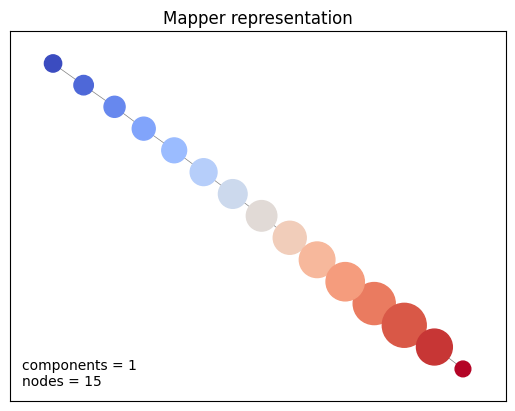

In [ ]:
plot_mapper(mappers['Logistic Regression'], max_node_size=1000)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Mapper representation'}>)

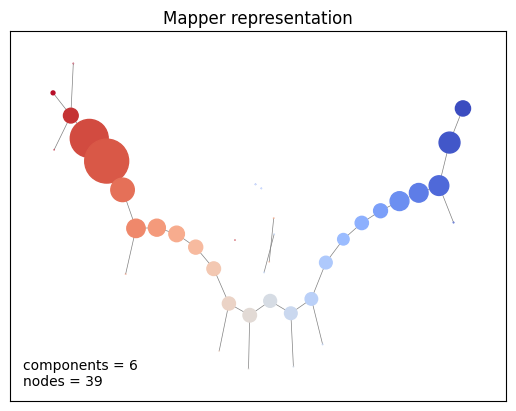

In [ ]:
plot_mapper(mappers['RBF SVM'], max_node_size=1000)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Extended persistence diagram'}>)

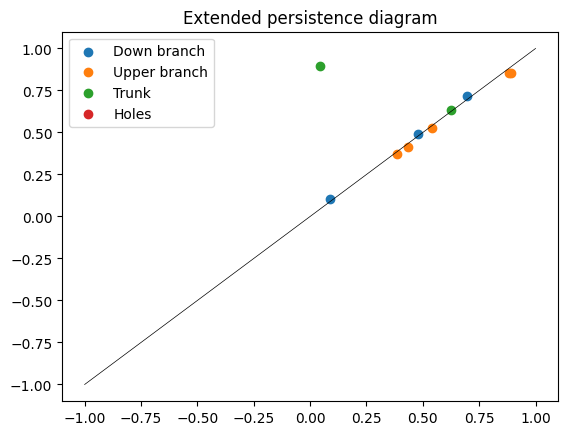

In [ ]:
plot_ext_persistance_diagram(mappers['RBF SVM'])

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Mapper representation'}>)

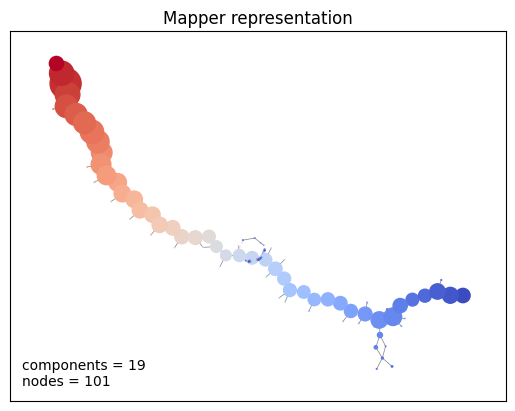

In [ ]:
plot_mapper(mappers['Random Forest'], max_node_size=500)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Mapper representation'}>)

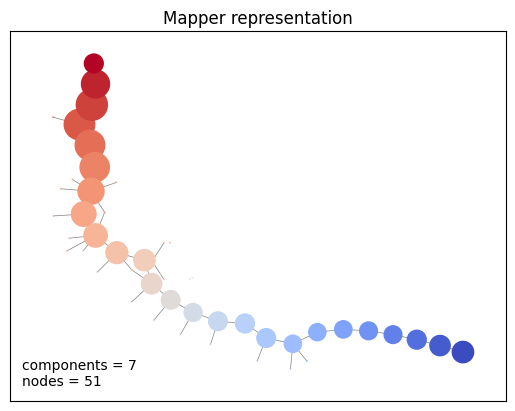

In [ ]:
plot_mapper(mappers['Neural Net'], max_node_size=500)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Extended persistence diagram'}>)

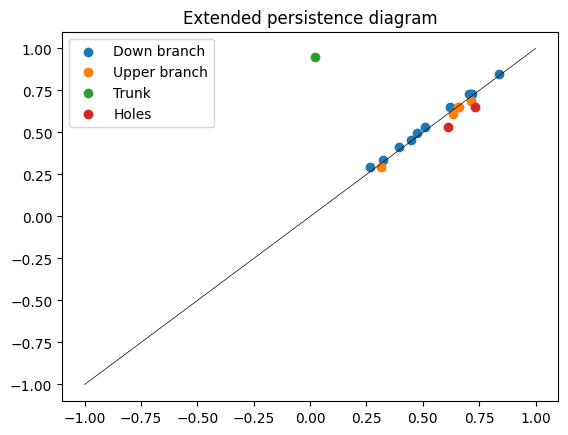

In [ ]:
plot_ext_persistance_diagram(mappers['Neural Net'])

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Mapper representation'}>)

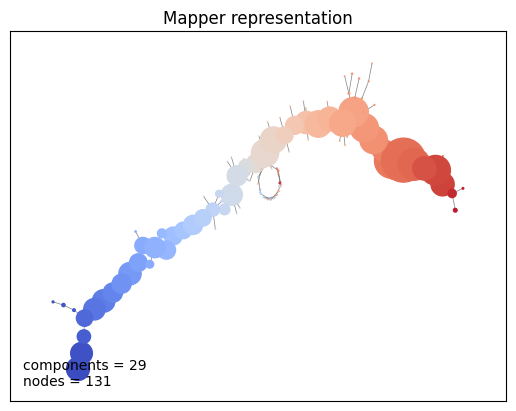

In [ ]:
plot_mapper(mappers['AdaBoost'], max_node_size=1000)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Extended persistence diagram'}>)

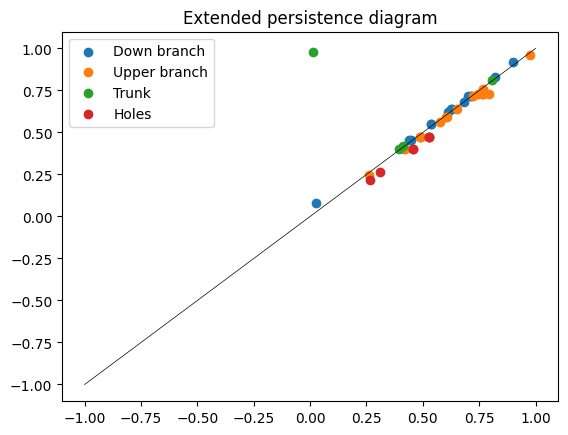

In [ ]:
plot_ext_persistance_diagram(mappers['AdaBoost'])

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Mapper representation'}>)

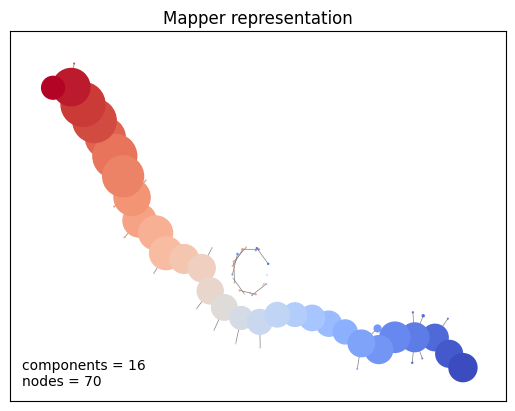

In [ ]:
plot_mapper(mappers['XGBoost'], max_node_size=1000)

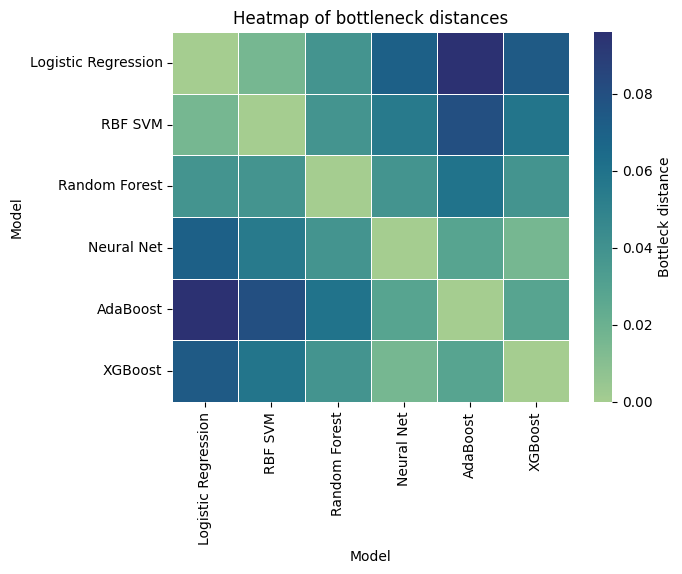

In [ ]:
import seaborn as sns

mappers_keys = list(mappers.keys())
bdistances = np.zeros((len(mappers_keys), len(mappers_keys)))

for i in range(len(mappers_keys)):
    name_i = mappers_keys[i]
    for j in range(len(mappers_keys)):
        name_j = mappers_keys[j]

        bdistances[i, j] = bottleneck_distance(mappers[name_i], mappers[name_j])

sns.heatmap(bdistances, linewidth=0.5, cmap="crest", yticklabels=names, xticklabels=names,
            cbar_kws={'label': 'Bottleck distance'})
plt.title('Heatmap of bottleneck distances')
plt.xlabel('Model')
plt.ylabel('Model')
plt.show()